In [380]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [381]:
data = pd.read_csv('202310-divvy-tripdata.csv')
data = data[pd.to_numeric(data['start_station_id'], errors='coerce').notnull()]
data = data[pd.to_numeric(data['end_station_id'], errors='coerce').notnull()]
data = data.dropna(subset=['start_station_id', 'end_station_id'])

In [382]:

start = pd.DataFrame(data['start_station_id'].value_counts())
end = pd.DataFrame(data['end_station_id'].value_counts())
start = start.rename(columns={'count': 'startcount'})
start.head()

,startcount
start_station_id,
13022,2230
13300,1883
13216,1310
15544,1284
13008,1258


In [383]:
end = end.rename(columns={'count': 'endcount'})
end.head()

,endcount
end_station_id,
13022,2546
13300,1703
13008,1403
13216,1305
13042,1289


In [384]:
stations = pd.concat([start['startcount'], end['endcount']], axis=1)
stations['total'] = stations['startcount'] + stations['endcount']
stations.head(10)
#stations['total'] = stations['start_station_id'] + stations['end_station_id']
#stations.head(10)

,startcount,endcount,total
13022,2230.0,2546.0,4776.0
13300,1883.0,1703.0,3586.0
13216,1310.0,1305.0,2615.0
15544,1284.0,1114.0,2398.0
13008,1258.0,1403.0,2661.0
13042,1150.0,1289.0,2439.0
13217,1092.0,1067.0,2159.0
13011,1004.0,943.0,1947.0
638,988.0,1047.0,2035.0
13061,965.0,964.0,1929.0


In [385]:
stats = stations.sort_values('total', ascending=False).head(10)
stats = list(stats.index)
print(stats)

['13022', '13300', '13008', '13216', '13042', '15544', '13217', '638', '13011', '13061']


In [608]:
# take out just these top stations from the data
divd = data[(data['start_station_id'].isin(stats)) | (data['end_station_id'].isin(stats))]
divd.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
603,A1B0885683D4B4CC,classic_bike,2023-10-13 18:31:25,2023-10-13 18:54:00,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,41.892278,-87.612043,41.921822,-87.644140,member
608,8BECFAB67F1FA81D,classic_bike,2023-10-22 17:44:50,2023-10-22 18:09:05,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,41.892278,-87.612043,41.921822,-87.644140,casual
1042,BE2395919F04F1E0,electric_bike,2023-10-28 15:56:13,2023-10-28 16:15:34,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062,41.892319,-87.612234,41.884114,-87.654264,member
1198,8527F766D559425F,electric_bike,2023-10-28 15:55:45,2023-10-28 16:15:36,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062,41.892313,-87.612226,41.884114,-87.654264,member
1200,A4A3170B63E200BB,electric_bike,2023-10-23 18:26:25,2023-10-23 18:41:07,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,41.892294,-87.612193,41.921822,-87.644140,member


In [609]:
print(divd.columns)

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


In [610]:
# don't need ride_id, rideable_type, start_lat, start_lng, end_lat, end_lng, or member_casual
divd = divd[['started_at', 'ended_at', 'start_station_name', 'start_station_id', 'end_station_name', 'end_station_id']]
divd.head()

,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id
603,2023-10-13 18:31:25,2023-10-13 18:54:00,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193
608,2023-10-22 17:44:50,2023-10-22 18:09:05,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193
1042,2023-10-28 15:56:13,2023-10-28 16:15:34,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062
1198,2023-10-28 15:55:45,2023-10-28 16:15:36,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062
1200,2023-10-23 18:26:25,2023-10-23 18:41:07,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193


In [611]:
# need to change started_at to month day and time
divd['started_at'] = pd.to_datetime(divd['started_at'])

divd['day'] = divd['started_at'].dt.day_name()

divd['month'] = divd['started_at'].dt.month_name()

divd['hours'] = divd['started_at'].map(lambda x: str(x)[11:13])
divd['hour'] = divd['hours']

divd.drop('started_at', axis=1, inplace=True)
divd.drop('ended_at', axis=1, inplace=True)
divd.head()

,start_station_name,start_station_id,end_station_name,end_station_id,day,month,hours,hour
603,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,Friday,October,18,18
608,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,Sunday,October,17,17
1042,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062,Saturday,October,15,15
1198,Streeter Dr & Grand Ave,13022,Aberdeen St & Randolph St,18062,Saturday,October,15,15
1200,Streeter Dr & Grand Ave,13022,Larrabee St & Webster Ave,13193,Monday,October,18,18


In [612]:
#divd['hour'] = divd['hours']
# group by starting station and the hour
divd = pd.DataFrame(divd.groupby(['start_station_name', 'hours'])['hour'].count())
divd = divd.rename(columns={'hour':'count'})
divd = divd.reset_index()
divd.index = divd['start_station_name']
print(divd.columns)
divd.head()

Index(['start_station_name', 'hours', 'count'], dtype='object')


,start_station_name,hours,count
start_station_name,,,
63rd St Beach,63rd St Beach,10,2
900 W Harrison St,900 W Harrison St,05,1
900 W Harrison St,900 W Harrison St,06,1
900 W Harrison St,900 W Harrison St,08,2
900 W Harrison St,900 W Harrison St,09,1


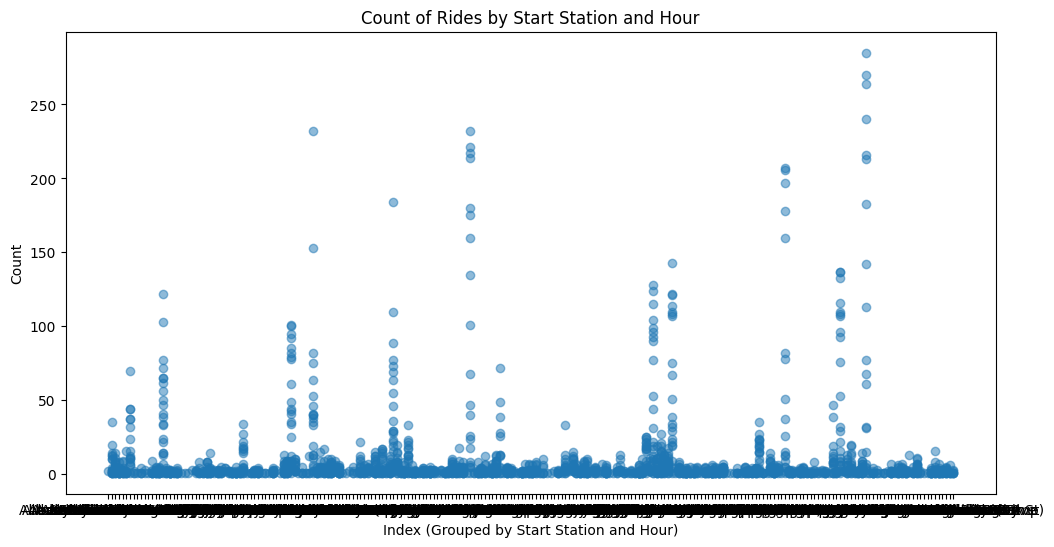

In [613]:
import matplotlib.pyplot as plt

# Assuming you have already run the groupby and reset_index operations
# divd = pd.DataFrame(divd.groupby(['start_station_name', 'hours'])['hour'].count())
# divd = divd.rename(columns={'hour':'count'})
# divd = divd.reset_index()

# Plotting the target column
plt.figure(figsize=(12, 6))
plt.scatter(divd.index, divd['count'], alpha=0.5)
plt.title('Count of Rides by Start Station and Hour')
plt.xlabel('Index (Grouped by Start Station and Hour)')
plt.ylabel('Count')
plt.show()

In [614]:
from sklearn.model_selection import train_test_split
# split into train and test data using sklearn.model_selection
features = ['start_station_name', 'hours']
X = pd.get_dummies(divd[features], columns=['start_station_name'], drop_first=True)
y = divd['count']
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
# xtrain = xtrain.to_numpy()
print("Training set shapes: xtrain: ", xtrain.shape, " ytrain: ", ytrain.shape)
print("Testing set shapes: xtest: ", xtest.shape, "ytest", ytest.shape)
weights = np.random.normal(0, 1, xtrain.shape[1])
bias = np.random.normal(0, 1, 1)
print(weights)
print(bias)

Training set shapes: xtrain:  (1522, 232)  ytrain:  (1522,)
Testing set shapes: xtest:  (381, 232) ytest (381,)
[-2.19708524e-01  1.54694418e+00 -1.68921268e-01  2.26742858e+00
 -5.81596068e-01 -3.80335864e-02 -1.00427686e+00 -7.50187703e-01
  1.16637330e+00  1.76745899e+00  8.92433870e-01 -1.07574402e+00
  4.43523966e-01  6.03902828e-01 -9.44062382e-01 -5.60065927e-01
 -2.52871243e-01 -1.08566680e+00  1.16638708e-01  9.34423966e-01
 -2.61558126e-01  1.15070127e+00 -8.16270343e-01 -1.86831464e+00
 -1.09834735e+00 -7.30020788e-01  1.79304304e+00  1.21087788e+00
  6.89892153e-01  7.10733479e-01 -5.59353712e-01 -1.26298446e+00
 -2.85227637e-01 -4.19958131e-01  1.07336587e+00  6.93237867e-03
 -2.77614528e-01  2.74358997e-01 -5.89878040e-01  2.28122230e+00
  5.85727281e-01  1.36153739e+00 -1.08148940e+00  9.29261404e-01
  1.14563387e+00  2.41590590e-01 -3.82897852e-01 -9.74108928e-01
  4.09064720e-01 -5.29400130e-01  1.02700026e+00  4.09898828e-01
  1.96833885e+00  1.38986350e-01 -8.6972267

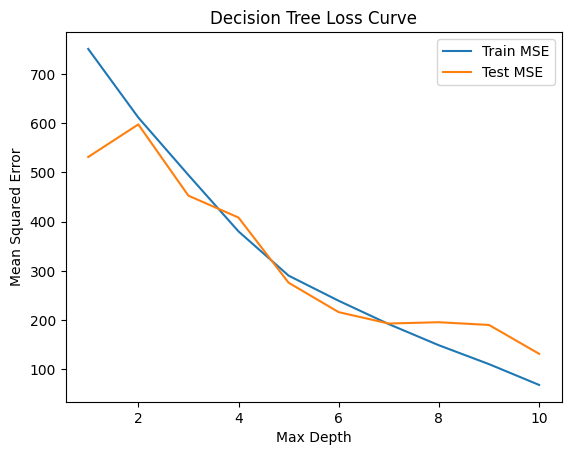

In [615]:
# vary tree depth from 1 to 10
md = np.arange(1, 11)
trerrors, terrors = [], []
for d in md:
    m = DecisionTreeRegressor(max_depth=d, random_state=42)
    m.fit(xtrain, ytrain)

    ytrpred = m.predict(xtrain)
    ytpred = m.predict(xtest)

    trerrors.append(mean_squared_error(ytrain, ytrpred))
    terrors.append(mean_squared_error(ytest, ytpred))

plt.plot(md, trerrors, label='Train MSE')
plt.plot(md, terrors, label='Test MSE')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('Decision Tree Loss Curve')
plt.legend()
plt.show()

In [582]:
# Create a Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)

In [583]:
# Train the model
tree_model.fit(xtrain, ytrain)

DecisionTreeRegressor(random_state=42)

In [584]:
# Predict on the test set
y_pred = tree_model.predict(xtest)

In [586]:
# Evaluate the model
mse = mean_squared_error(ytest, y_pred)
r2 = r2_score(ytest, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 80.85826771653544
R-squared: 0.7999080844623294


In [587]:
# Cross-validation
cv_scores = cross_val_score(tree_model, X, y, cv=5)
print(f'Cross-validation Scores: {cv_scores}')

Cross-validation Scores: [-0.18578454 -0.13012444 -0.06895957 -0.16735423 -0.11044304]


In [588]:
# Feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': tree_model.feature_importances_})
feature_importances = feature_importances.sort_values('Importance', ascending=False)
print('Feature Importances:')
print(feature_importances.head())

Feature Importances:
                                               Feature  Importance
0                                                hours    0.483260
207         start_station_name_Streeter Dr & Grand Ave    0.177193
99   start_station_name_DuSable Lake Shore Dr & Mon...    0.093948
185                  start_station_name_Shedd Aquarium    0.060209
200              start_station_name_State St & 33rd St    0.032891


Accuracy: 0.8136482939632546


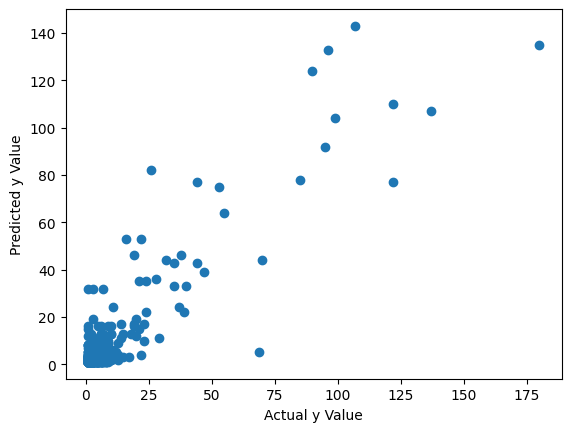

In [591]:
# Set a threshold to classify as high or low
threshold = 5  # You can adjust this threshold based on your problem

# Convert regression predictions to binary classification
y_pred_class = (y_pred > threshold).astype(int)
ytest_class = (ytest > threshold).astype(int)

# Calculate accuracy
accuracy = np.mean(y_pred_class == ytest_class)

print(f'Accuracy: {accuracy}')
plt.scatter(ytest, y_pred)
plt.xlabel('Actual y Value')
plt.ylabel('Predicted y Value')
plt.show()

Mean Squared Error:  1.321945968642283e+25
R-Squared:  -3.2712882500801286e+22
Testing Accuracy:  1.0


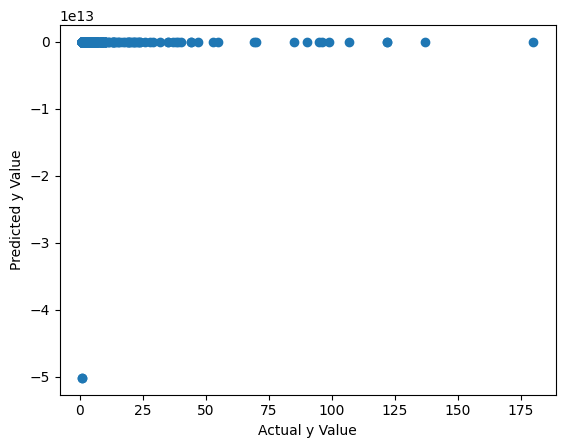

In [590]:

lrm = LinearRegression()
lrm.fit(xtrain, ytrain)
predict = lrm.predict(xtest)
mse = mean_squared_error(ytest, predict)
r2 = r2_score(ytest, predict)
print("Mean Squared Error: ", mse)
print("R-Squared: ", r2)
print('Testing Accuracy: ', lrm.score(xtest, predict))

plt.scatter(ytest, predict)
plt.xlabel('Actual y Value')
plt.ylabel('Predicted y Value')
plt.show()

In [571]:
# Set a threshold to classify as high or low
threshold = 10  # You can adjust this threshold based on your problem

# Convert regression predictions to binary classification
pred_class = (predict > threshold).astype(int)
ytest_class = (ytest > threshold).astype(int)

# Calculate accuracy
accuracy = np.mean(pred_class == ytest_class)

print(f'Accuracy: {accuracy}')

Accuracy: 0.905511811023622


In [592]:
print(divd)

                            start_station_name hours  count
start_station_name                                         
63rd St Beach                    63rd St Beach    10      2
900 W Harrison St            900 W Harrison St    05      1
900 W Harrison St            900 W Harrison St    06      1
900 W Harrison St            900 W Harrison St    08      2
900 W Harrison St            900 W Harrison St    09      1
...                                        ...   ...    ...
Woodlawn Ave & 58th St  Woodlawn Ave & 58th St    12      1
Woodlawn Ave & 58th St  Woodlawn Ave & 58th St    15      1
Woodlawn Ave & 58th St  Woodlawn Ave & 58th St    16      2
Woodlawn Ave & 58th St  Woodlawn Ave & 58th St    17      3
Woodlawn Ave & 58th St  Woodlawn Ave & 58th St    18      1

[1903 rows x 3 columns]


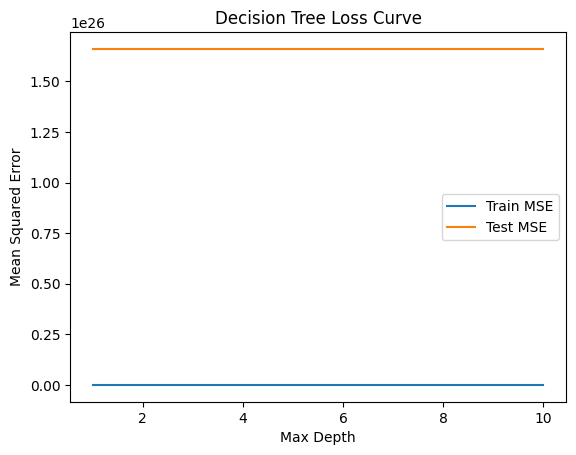

Mean Squared Error: 1.66054797316402e+26
R-squared: -4.1091929641307154e+23


In [619]:
from sklearn.preprocessing import StandardScaler

lrX = divd[['start_station_name', 'hours']]
lry = divd['count']

# One-hot encode categorical features
lrX_encoded = pd.get_dummies(lrX, columns=['start_station_name'], drop_first=True)

# Normalize numerical features
scaler = StandardScaler()
lrX_encoded[['hours']] = scaler.fit_transform(lrX_encoded[['hours']])

# Split the data
xtrain, xtest, ytrain, ytest = train_test_split(lrX_encoded, lry, test_size=0.2, random_state=42)

# vary tree depth from 1 to 10
md = np.arange(1, 11)
trerrors, terrors = [], []
for d in md:
    m = LinearRegression()
    m.fit(xtrain, ytrain)

    ytrpred = m.predict(xtrain)
    ytpred = m.predict(xtest)

    trerrors.append(mean_squared_error(ytrain, ytrpred))
    terrors.append(mean_squared_error(ytest, ytpred))

plt.plot(md, trerrors, label='Train MSE')
plt.plot(md, terrors, label='Test MSE')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('Decision Tree Loss Curve')
plt.legend()
plt.show()

# Make predictions
ypred = lrm.predict(xtest)

# Evaluate the model
mse = mean_squared_error(ytest, ypred)
r2 = r2_score(ytest, ypred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)


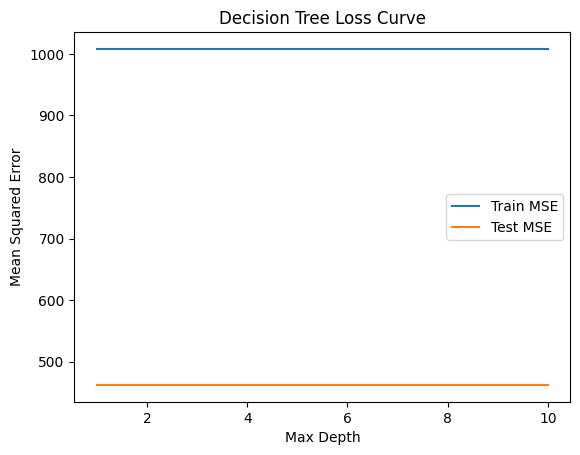

In [620]:
from sklearn import svm
# vary tree depth from 1 to 10
md = np.arange(1, 11)
trerrors, terrors = [], []
for d in md:
    m = svm.SVC(kernel='rbf', random_state=42)
    m.fit(xtrain, ytrain)

    ytrpred = m.predict(xtrain)
    ytpred = m.predict(xtest)

    trerrors.append(mean_squared_error(ytrain, ytrpred))
    terrors.append(mean_squared_error(ytest, ytpred))

plt.plot(md, trerrors, label='Train MSE')
plt.plot(md, terrors, label='Test MSE')
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.title('Decision Tree Loss Curve')
plt.legend()
plt.show()

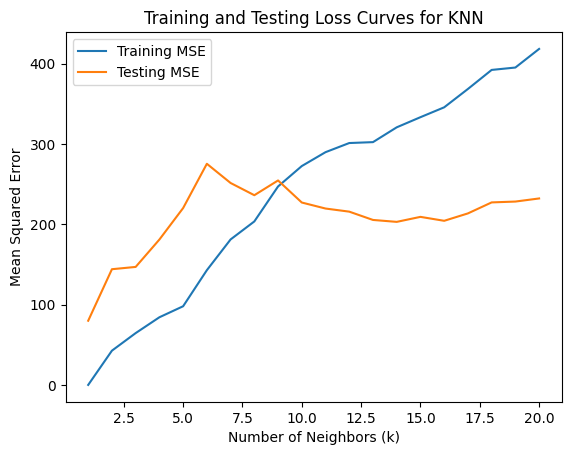

In [621]:
from sklearn.neighbors import KNeighborsRegressor

# Assume xtrain, xtest, ytrain, ytest are already defined

# Define a range of k values
k_values = range(1, 21)  # You can adjust this range based on your preferences

trerrors = []
terrors = []

for k in k_values:
    # Train the KNN model
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(xtrain, ytrain)
    
    # Predictions on training set
    train_pred = knn_model.predict(xtrain)
    train_mse = mean_squared_error(ytrain, train_pred)
    trerrors.append(train_mse)
    
    # Predictions on testing set
    test_pred = knn_model.predict(xtest)
    test_mse = mean_squared_error(ytest, test_pred)
    terrors.append(test_mse)

plt.plot(k_values, trerrors, label='Training MSE')
plt.plot(k_values, terrors, label='Testing MSE')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Testing Loss Curves for KNN')
plt.show()

In [622]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(xtrain, ytrain)
kpred = knn.predict(xtest)
kmse = mean_squared_error(ytest, kpred)
kr2 = r2_score(ytest, kpred)
print(f"Mean Squared Error: {kmse}")
print(f"R-squared: {kr2}")

Mean Squared Error: 220.13123359580052
R-squared: 0.45526312344128184


In [624]:
# Set a threshold to classify as high or low
threshold = 5  # You can adjust this threshold based on your problem

# Convert regression predictions to binary classification
kpred_class = (kpred > threshold).astype(int)
ytest_class = (ytest > threshold).astype(int)

# Calculate accuracy
accuracy = np.mean(kpred_class == ytest_class)
print(f"Accuracy: {accuracy}")


Accuracy: 0.7769028871391076
